In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.stats import truncnorm

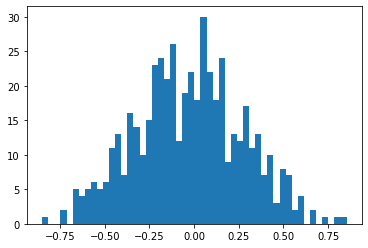

In [2]:
# https://stackoverflow.com/questions/36894191/how-to-get-a-normal-distribution-within-a-range-in-numpy
def get_truncated_normal(mean=0, sd=0.3, low=-1, upp=1):
    return truncnorm(
        (low - mean)/sd, 
        (upp - mean)/sd, 
        loc = mean, 
        scale = sd)

X = get_truncated_normal()
plt.hist(X.rvs(500), bins = 50)
plt.show()

In [6]:
class post:
    
    def __init__(self, kind, user_ideology, user_trust):
        self.type = kind   # binary: either post (1) or comment (0)
        
        # post's ideology score
        self.ideology = get_truncated_normal(mean=user_ideology, sd=0.2, low=-1, upp=1).rvs()  
        
        # post's trustworthiness
        self.trust = get_truncated_normal(mean=user_trust, sd=0.1, low=0, upp=1).rvs()  

In [4]:
class user:
    def __init__(self):
        self.ideology = get_truncated_normal(mean=0, sd=0.3, low=-1, upp=1).rvs()
        self.care = get_truncated_normal(mean=0, sd=0.3, low=-1, upp=1).rvs()

def create_n_users (n):
    user_list = []
    for i in range(n):
        user_list.append(user())
    return user_list

In [5]:
newpost = post(1)
print(newpost.type, newpost.ideology, newpost.trust)

user_list = create_n_users(100)
for user in user_list:
    print(user.ideology, user.care)

1 -0.10185294045071687 0.6137461566130943
-0.21875475997301744 0.1295866617290578
0.016335749446385234 0.17173716489621813
0.17900098127731087 0.025177959847468574
-0.42439963813236703 0.42346847039490826
0.3954736844490238 -0.05655463304785722
-0.315104567865213 -0.1284600173278034
-0.008139463141949545 -0.7251220165560822
-0.175810292913995 0.11306998011242392
0.11789949902005067 0.020326947047050545
0.26458523172735954 -0.11194103304836091
0.5623652811501239 -0.28598496095755754
-0.03289422271219863 -0.13212231922395212
0.10776712554469266 0.5496539447262409
0.1364787687408878 0.3686148430042043
0.5322283764585588 0.2585334429229896
-0.1630695199451961 0.1264726311530444
0.6317426929665168 0.3510165804211841
0.10549351926429407 0.026129453713281778
-0.3354070778259052 0.2847289419447909
0.3219460561714892 -0.2195433528046512
-0.03825689654334805 -0.2133472247406483
-0.10546630872169298 0.12599343751483583
0.10849780695734716 0.02369204949045493
0.13912263759149174 -0.277242611017425